In [8]:
!pip install pandas-datareader
!pip install yfinance
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import seaborn as sns
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

import yfinance as yf
import pandas_datareader as pdr 
import FinanceDataReader as fdr 

In [15]:
start = datetime(2020,1,1)
end = datetime.today()

ss = yf.download('005930.KS',start,end) 

[*********************100%***********************]  1 of 1 completed


In [16]:
ss.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,55500.0,56000.0,55000.0,55200.0,50287.113281,12993228
2020-01-03,56000.0,56600.0,54900.0,55500.0,50560.417969,15422255
2020-01-06,54900.0,55600.0,54600.0,55500.0,50560.417969,10278951
2020-01-07,55700.0,56400.0,55600.0,55800.0,50833.714844,10009778
2020-01-08,56200.0,57400.0,55900.0,56800.0,51744.718750,23501171


<Axes: xlabel='Date'>

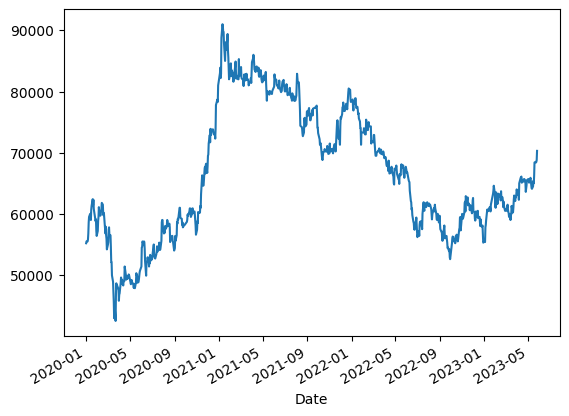

In [17]:
ss['Close'].plot()

In [19]:
# Create short(long) simple moving average over the short(long) window

short_window = 20
long_window = 80

signals = pd.DataFrame(index=ss.index)
signals['signal'] = 0.0

signals['short_mavg'] = ss['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg'] = ss['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

In [20]:
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:]
                                             > signals['long_mavg'][short_window:], 1.0, 0.0)

signals['positions'] = signals['signal'].diff()

print(signals)

            signal  short_mavg  long_mavg  positions
Date                                                
2020-01-02     0.0     55200.0   55200.00        NaN
2020-01-03     0.0     55350.0   55350.00        0.0
2020-01-06     0.0     55400.0   55400.00        0.0
2020-01-07     0.0     55500.0   55500.00        0.0
2020-01-08     0.0     55760.0   55760.00        0.0
...            ...         ...        ...        ...
2023-05-22     1.0     65350.0   63243.75        0.0
2023-05-23     1.0     65485.0   63301.25        0.0
2023-05-24     1.0     65650.0   63350.00        0.0
2023-05-25     1.0     65910.0   63418.75        0.0
2023-05-26     1.0     66220.0   63530.00        0.0

[840 rows x 4 columns]


<Axes: xlabel='Date'>

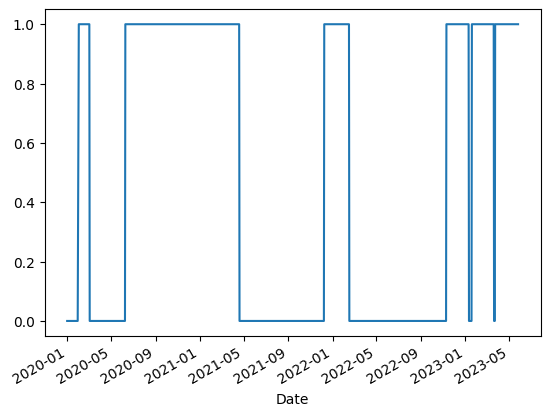

In [21]:
signals.signal.plot()

<Axes: xlabel='Date'>

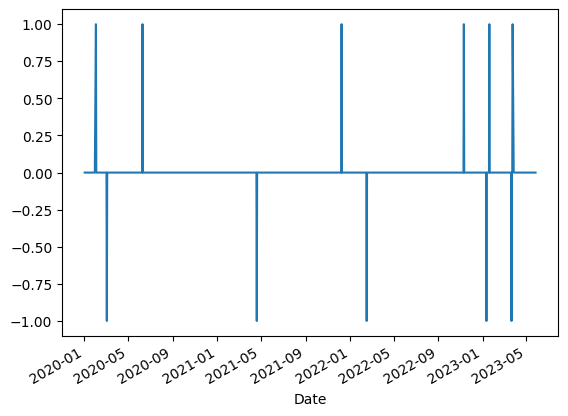

In [22]:
signals.positions.plot()

<function matplotlib.pyplot.show(close=None, block=None)>

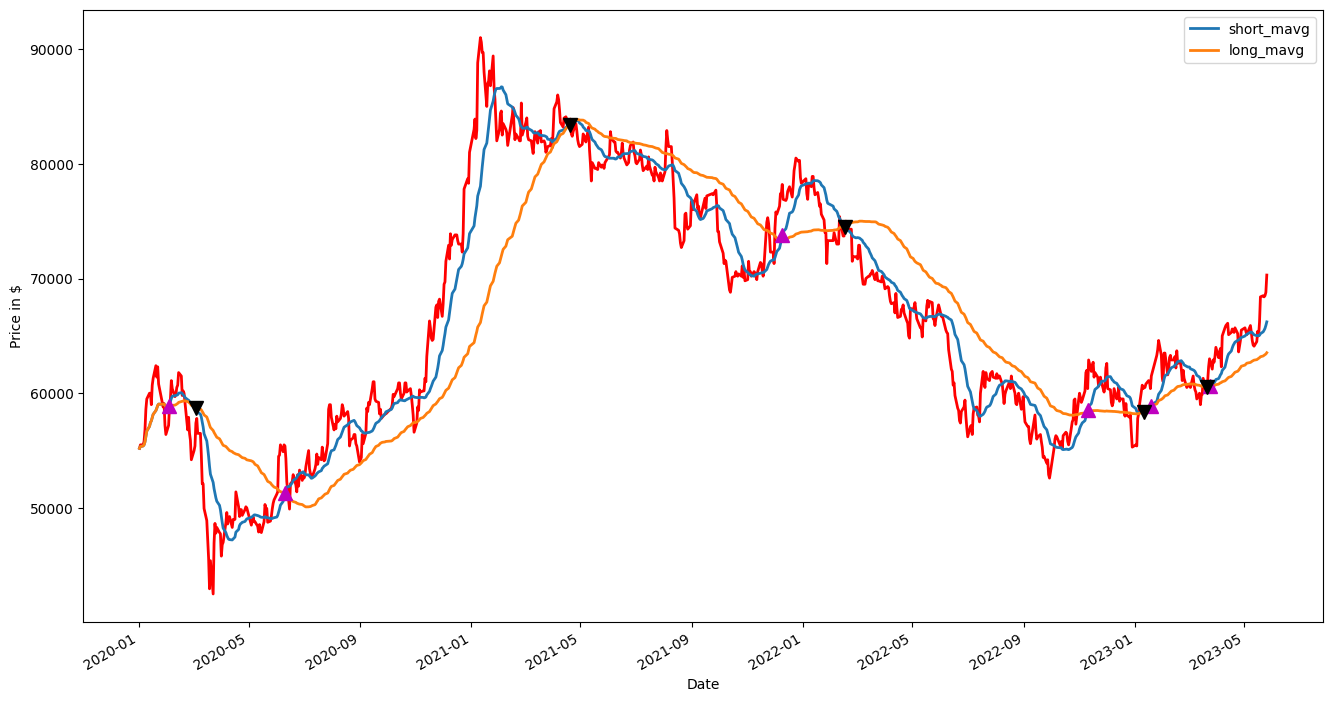

In [30]:
# Plot the closing price
# Plot the short & long moving averages

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111, ylabel='Price in $')
ss['Close'].plot(ax=ax1, color='r', lw=2.)
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)


# Plot the buy & sell signals

ax1.plot(signals.loc[signals.positions == 1.0].index,
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color= 'm')

ax1.plot(signals.loc[signals.positions == -1.0].index,
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color= 'k')

plt.show  

Evaluation

In [31]:
initial_capital= float(10000000.0)

positions = pd.DataFrame(index=signals.index).fillna(0.0)
positions['SS'] = 100*signals['signal']
portfolio = positions.multiply(ss['Close'], axis=0)
pos_diff = positions.diff()

In [33]:
# Add items to portfolio

portfolio['holdings'] = (positions.multiply(ss['Close'], axis=0)).sum(axis=1)
portfolio['cash'] =initial_capital - (pos_diff.multiply(ss['Close'], axis=0)).sum(axis=1).cumsum()
portfolio['total'] = portfolio['cash'] + portfolio['holdings']
portfolio['returns'] = portfolio['total'].pct_change()*100

In [34]:

portfolio['Close'] = ss['Close']
portfolio['ret_Close'] = ss['Close'].pct_change()*100

portfolio['ret_position'] = portfolio['ret_Close'].mul(signals['signal'])
portfolio['signal'] = signals['signal']
portfolio['positions'] = signals['positions']

print(portfolio)

                   SS   holdings        cash       total   returns    Close  \
Date                                                                          
2020-01-02        0.0        0.0  10000000.0  10000000.0       NaN  55200.0   
2020-01-03        0.0        0.0  10000000.0  10000000.0  0.000000  55500.0   
2020-01-06        0.0        0.0  10000000.0  10000000.0  0.000000  55500.0   
2020-01-07        0.0        0.0  10000000.0  10000000.0  0.000000  55800.0   
2020-01-08        0.0        0.0  10000000.0  10000000.0  0.000000  56800.0   
...               ...        ...         ...         ...       ...      ...   
2023-05-22  6850000.0  6850000.0   6120000.0  12970000.0  0.077160  68500.0   
2023-05-23  6840000.0  6840000.0   6120000.0  12960000.0 -0.077101  68400.0   
2023-05-24  6850000.0  6850000.0   6120000.0  12970000.0  0.077160  68500.0   
2023-05-25  6880000.0  6880000.0   6120000.0  13000000.0  0.231303  68800.0   
2023-05-26  7030000.0  7030000.0   6120000.0  131500

<Axes: xlabel='Date'>

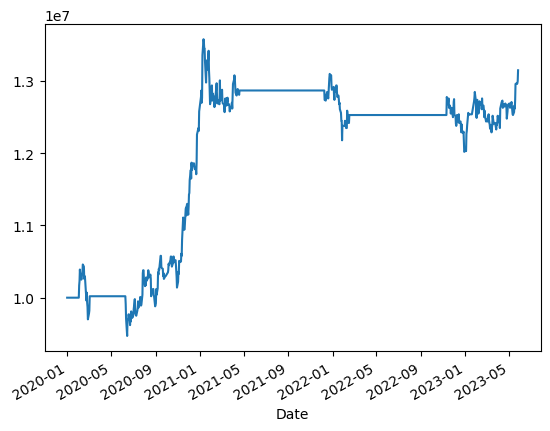

In [35]:
portfolio.total.plot()

<function matplotlib.pyplot.show(close=None, block=None)>

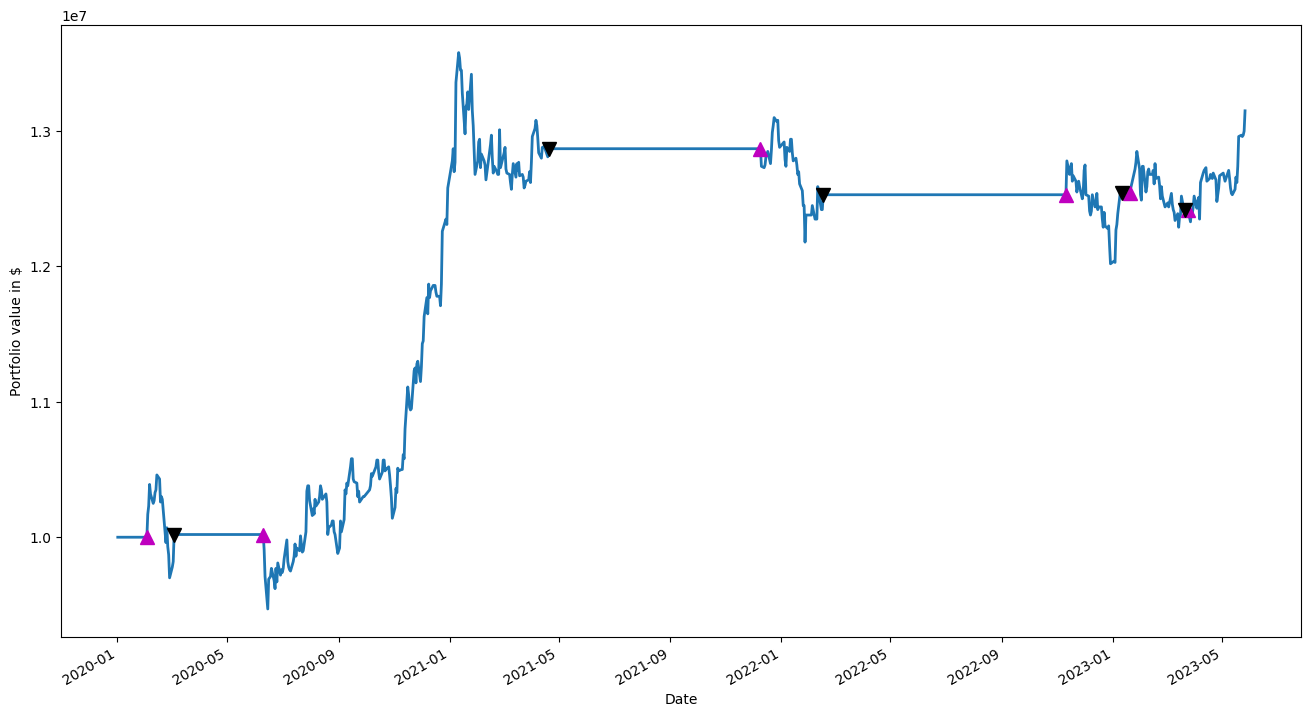

In [36]:
# Plot the Equity curve in dollars

fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111, ylabel = 'Portfolio value in $')

portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index,
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
ax1.plot(portfolio.loc[signals.positions == -1.0].index,
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

plt.show

Sharpe Ratio

In [37]:
# Isolate the returns

returns = portfolio['returns']

sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())
print(sharpe_ratio)

0.8406824009838193


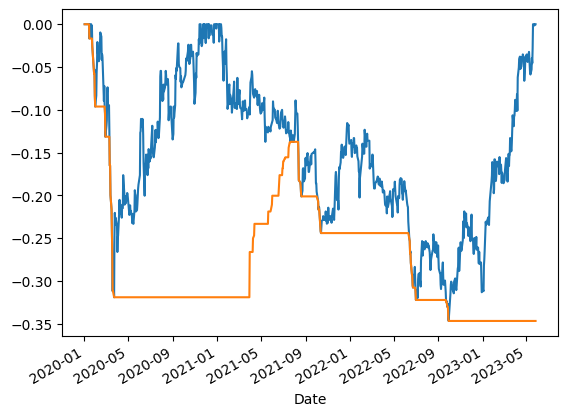

In [39]:
# define a trailing 252 trading day window
# Calculate the max (minimum) daily drawdown in the past window days

window = 252

rolling_max = ss['Close'].rolling(window, min_periods=1).max()
daily_drawdown = ss['Close']/rolling_max - 1.0

max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

daily_drawdown.plot()
max_daily_drawdown.plot()

plt.show()

In [45]:
# Caculate the CAGR (Compound Annual Growth Rate)

days = (ss.index[-1] - ss.index[0]).days

cagr = (((((ss['Close'][-1]) / ss['Close'][0])) ** (365.0/days)) - 1 )*100

print(cagr)

7.377191482684697


In [46]:
portfolio

,SS,holdings,cash,total,returns,Close,ret_Close,ret_position,signal,positions
Date,,,,,,,,,,
2020-01-02,0.0,0.0,10000000.0,10000000.0,NaN,55200.0,NaN,NaN,0.0,NaN
2020-01-03,0.0,0.0,10000000.0,10000000.0,0.000000,55500.0,0.543478,0.000000,0.0,0.0
2020-01-06,0.0,0.0,10000000.0,10000000.0,0.000000,55500.0,0.000000,0.000000,0.0,0.0
2020-01-07,0.0,0.0,10000000.0,10000000.0,0.000000,55800.0,0.540541,0.000000,0.0,0.0
2020-01-08,0.0,0.0,10000000.0,10000000.0,0.000000,56800.0,1.792115,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-05-22,6850000.0,6850000.0,6120000.0,12970000.0,0.077160,68500.0,0.146199,0.146199,1.0,0.0
2023-05-23,6840000.0,6840000.0,6120000.0,12960000.0,-0.077101,68400.0,-0.145985,-0.145985,1.0,0.0
2023-05-24,6850000.0,6850000.0,6120000.0,12970000.0,0.077160,68500.0,0.146199,0.146199,1.0,0.0


In [47]:
ret_ss_hpr = 100 * np.log(ss.Close[-1]/ss.Close[0])
ret_ss_hpr

24.18088455335696

In [48]:
ret_strategy = portfolio['ret_position'].sum()
ret_strategy

48.57061050240106

<Axes: xlabel='Date'>

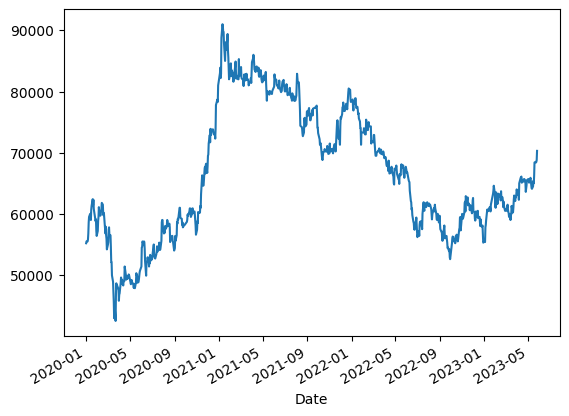

In [49]:
ss.Close.plot()